## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rioxarray as rxr
import geopandas as gpd

## Import Files

In [124]:
directory = '../Landsat_Data/DSWE_CRB/'
landsat = [file for file in os.listdir(directory) if (file.startswith("LT05_CU_011009_") or file.startswith("LC08_CU_011009_"))]
print(len(landsat))

2057


## Test Tools for Tile Access

In [227]:
tiff_file = rxr.open_rasterio(directory + landsat[0])
tiff_file

<xarray.DataArray (band: 1, y: 5000, x: 5000)>
[25000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -9.156e+05 -9.155e+05 ... -7.656e+05 -7.656e+05
  * y            (y) float64 1.965e+06 1.965e+06 ... 1.815e+06 1.815e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     dynamic surface water extent: filtered by: percent slope -...

For some reason the x values are sorted to increase in value, whereas the y values are sorted to decrease in value. Due to this, the slicing on the y values must be flipped (ie. y=slice(larger value, smaller value))

In [221]:
tiff_file.rio.crs

CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [222]:
tiff_file.rio.bounds()

(-915585.0, 1814805.0, -765585.0, 1964805.0)

Slicing around just the reservoir and immediate feed into it.

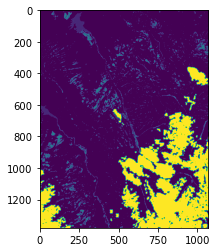

In [226]:
tiff_file = rxr.open_rasterio(directory + landsat[12])
tiff_file_sliced = tiff_file.sel(x=slice(-869535, -837405), y=slice(1937595, 1896195))
plt.imshow(tiff_file_sliced[0])

In [134]:
np.array(tiff_file)

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ...,   9,   9,   9],
        [255, 255, 255, ...,   9,   9,   9],
        [255, 255, 255, ...,   9,   9,   9]]], dtype=uint8)

## Filter Tiles to Region of Interest

<AxesSubplot:>

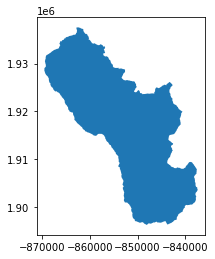

In [88]:
shape = gpd.read_file("../Landsat_Data/DSWE_Williams_Fork_SHPs/StaID09038500.shp")
shape.plot()

In [89]:
print(shape.bounds)

       minx       miny      maxx       maxy
0 -869535.0  1896195.0 -837405.0  1937595.0


In [90]:
tiff_file.x

<xarray.DataArray 'x' (x: 5000)>
array([-915570., -915540., -915510., ..., -765660., -765630., -765600.])
Coordinates:
  * x            (x) float64 -9.156e+05 -9.155e+05 ... -7.656e+05 -7.656e+05
    spatial_ref  int64 0

In [91]:
tiff_file.y

<xarray.DataArray 'y' (y: 5000)>
array([1964790., 1964760., 1964730., ..., 1814880., 1814850., 1814820.])
Coordinates:
  * y            (y) float64 1.965e+06 1.965e+06 ... 1.815e+06 1.815e+06
    spatial_ref  int64 0

For some reason the x values are sorted to increase in value, whereas the y values are sorted to decrease in value. Due to this, the slicing on the y values must be flipped (ie. y=slice(larger value, smaller value)). This slicing is to cut around just the watershed.

In [92]:
tiff_file_sliced = tiff_file.sel(x=slice(-869535, -837405), y=slice(1937595, 1896195))
tiff_file_sliced

<xarray.DataArray (band: 1, y: 1380, x: 1071)>
[1477980 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -8.695e+05 -8.695e+05 ... -8.374e+05 -8.374e+05
  * y            (y) float64 1.938e+06 1.938e+06 ... 1.896e+06 1.896e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     dynamic surface water extent: filtered by: percent slope -...

## Find Clear Tiles in Region of Interest

"lst_clear" tiles == Tiles with no null values and at least aren't completely cloud covered

In [196]:
for file in landsat:
    tiff_file = rxr.open_rasterio(directory + file)
    tiff_file_sliced = tiff_file.sel(x=slice(-864520, -854520), y=slice(1937395, 1927395))
    print(np.unique(tiff_file_sliced.values, return_counts=True))

(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103387,   5520,     30,    117,   2168]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([  2270,   3714,      3,      6,      2, 105227]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([51745,  5291,   152,   170,   892, 52972]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([99005,  5899,    43,   311,  1595,  4369]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([100915,   6433,     57,    276,   3541]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([  2026,     31,     20,    118, 109027]))
(array([0, 4, 9], dtype=uint8), array([  1526,     11, 109685]))
(array([255], dtype=uint8), array(

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([  0,   1,   2,   3,   4,   9, 255], dtype=uint8), array([28488,  1508,   621,  2618,  1623,  6483, 69881]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([101834,   6544,     69,    426,   2349]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([  7445,     65,     37,     59,    177, 103439]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([102863,   5937,     44,    225,   1520,    633]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([102717,   6050,     29,    446,   1980]))
(array([255], dtype=u

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([  0, 255], dtype=uint8), array([   322, 110900]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 9], dtype=uint8), array([   178, 111044]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([   132,     12,     21,     24, 111033]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([102627,   6389,     79,    548,   1579]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([   913,      2,      1,     13, 110293]))
(array([255], dtype=uint8), array([111222]

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([104989,   4953,     29,    157,   1094]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([  4431,    270,   5169,     17,     30, 101305]))
(array([255

(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([104681,   5846,     37,    260,    398]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103372,   5401,     95,    442,   1912]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([80945,  4605,   652,  1684,  4547, 18789]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103672,   6375,     37,    294,    844]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dty

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([32446,   277,   216,   128,  1141, 77014]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([  1270,   4818,      1,      1, 105132]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([102862,   6525,     56,    345,   1434]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 9], dtype=uint8), array([    13, 111209]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 9], dtype=uint8), array([   106,   5118, 105998]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([54711,   104,     9,   464,  1637, 54297]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), arra

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([80526,  4147,    19,  1119,  3719, 21692]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([31526,  3386,    38,   213,  1332, 74727]))
(array([255], dtype=uint8), array([111222]))
(array([

(array([0, 1, 2, 3, 4], dtype=uint8), array([103899,   3570,   1178,   1641,    934]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103865,   5609,     37,    418,   1293]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103608,   6557,     67,    264,    726]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([100731,   6515,     66,    811,   2801,    298]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([104341,   5985,     40,    192,    664]))
(array([255], dtype=uint8), array([111222]))
(array([255], 

(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([99755,  5541,    65,   416,   945,  4500]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([104448,   5671,     41,    111,    951]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 2, 4, 9], dtype=uint8), array([  3516,     44,     10, 107652]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([11818,  2779,   105,   173,   292, 96055]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8),

(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([102438,   6432,     65,    318,   1969]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([97370,   214,  3778,  2320,   854,  6686]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([   685,      2,      7,      1, 110527]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103680,   6196,    117,    388,    841]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dty

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([  2798,      1,      5,     11, 108407]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255],

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([104774,   5758,     50,    273,    367]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103749,   6482,     45,    180,    766]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([11555,  2525,   533,     8,   207, 96394]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3

(array([255], dtype=uint8), array([111222]))
(array([0, 1, 3, 4, 9], dtype=uint8), array([21989,     2,    36,   999, 88196]))
(array([9], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([87180,  5337,    32,   349,  1083, 17241]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([28711,  1458,    39,    82,  1104, 79828]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([  0,   4,   9, 255], dtype=uint8), array([   323,      1,   5616, 105282]))
(array([255], dtype=uint8)

(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([9], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 4, 9], dtype=uint8), array([  4037,      1,     84,      7, 107093]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([102312,   5600,     36,    250,   3024]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4, 9], dtype=uint8), array([70833,  4264,   170,   919,   757, 34279]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([0, 1, 2, 3, 4], dtype=uint8), array([103948,   5741,     37,    224,   1272]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype=uint8), array([111222]))
(array([255], dtype

In [215]:
lst_clear = []
nan_files = []
for file in landsat:
    tiff_file = rxr.open_rasterio(directory + file)
    tiff_file_sliced = tiff_file.sel(x=slice(-864520, -854520), y=slice(1937395, 1927395))  # slicing around just reservoir
    
    # If there are null values or if the tile is entirely cloud cover, drop it
    if (255 in tiff_file_sliced.values) or (np.unique(tiff_file_sliced.values, return_counts=True)[0][0] == 9):
        nan_files.append(file)
    else:
        num_values = tiff_file_sliced.x.size * tiff_file_sliced.y.size
        result = np.unique(tiff_file_sliced.values, return_counts=True)
        cloud_values = 0
        for i in range(0, len(result[0])):
            if result[0][i] == 9:
                cloud_values += result[1][i]
        if cloud_values / num_values == 0:  # only include cloudless tiles
            lst_clear.append(file)
        else:
print(len(lst_clear))
print(len(nan_files))

155
1902


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 9],
       [9, 9, 9, ..., 0, 0, 9],
       [9, 9, 9, ..., 0, 0, 0]], dtype=uint8)

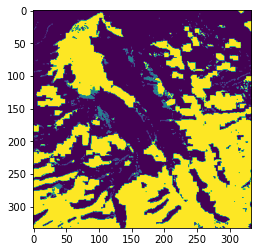

In [216]:
tiff_file = rxr.open_rasterio(directory + "LT05_CU_011009_19850413_20190205_C01_V01_INWM.tif")
tiff_file_sliced = tiff_file.sel(x=slice(-864520, -854520), y=slice(1937395, 1927395))
plt.imshow(tiff_file_sliced.values[0])
np.array(tiff_file_sliced.values[0])

In [217]:
lst_clear.sort()
lst_clear

['LC08_CU_011009_20130629_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20130816_20190506_C01_V01_INWM.tif',
 'LC08_CU_011009_20140531_20181208_C01_V01_INWM.tif',
 'LC08_CU_011009_20140702_20190208_C01_V01_INWM.tif',
 'LC08_CU_011009_20140803_20190208_C01_V01_INWM.tif',
 'LC08_CU_011009_20140920_20181207_C01_V01_INWM.tif',
 'LC08_CU_011009_20150502_20190607_C01_V01_INWM.tif',
 'LC08_CU_011009_20150603_20181206_C01_V01_INWM.tif',
 'LC08_CU_011009_20150619_20181206_C01_V01_INWM.tif',
 'LC08_CU_011009_20160605_20181210_C01_V01_INWM.tif',
 'LC08_CU_011009_20160621_20181211_C01_V01_INWM.tif',
 'LC08_CU_011009_20160723_20181204_C01_V01_INWM.tif',
 'LC08_CU_011009_20160909_20181209_C01_V01_INWM.tif',
 'LC08_CU_011009_20161027_20181128_C01_V01_INWM.tif',
 'LC08_CU_011009_20161112_20181128_C01_V01_INWM.tif',
 'LC08_CU_011009_20170608_20181127_C01_V01_INWM.tif',
 'LC08_CU_011009_20170624_20181127_C01_V01_INWM.tif',
 'LC08_CU_011009_20170912_20181126_C01_V01_INWM.tif',
 'LC08_CU_011009_20180510_20

In [218]:
tile_files = sorted(lst_clear, key=lambda x: x.split('_')[3])
tile_files

['LT05_CU_011009_19840528_20190206_C01_V01_INWM.tif',
 'LT05_CU_011009_19840613_20190604_C01_V01_INWM.tif',
 'LT05_CU_011009_19840629_20190604_C01_V01_INWM.tif',
 'LT05_CU_011009_19860603_20190603_C01_V01_INWM.tif',
 'LT05_CU_011009_19860619_20190603_C01_V01_INWM.tif',
 'LT05_CU_011009_19860721_20190603_C01_V01_INWM.tif',
 'LT05_CU_011009_19860806_20190603_C01_V01_INWM.tif',
 'LT05_CU_011009_19861009_20190602_C01_V01_INWM.tif',
 'LT05_CU_011009_19870622_20190203_C01_V01_INWM.tif',
 'LT05_CU_011009_19870708_20190203_C01_V01_INWM.tif',
 'LT05_CU_011009_19870724_20190203_C01_V01_INWM.tif',
 'LT05_CU_011009_19870910_20190601_C01_V01_INWM.tif',
 'LT05_CU_011009_19870926_20190601_C01_V01_INWM.tif',
 'LT05_CU_011009_19880523_20190531_C01_V01_INWM.tif',
 'LT05_CU_011009_19880608_20190531_C01_V01_INWM.tif',
 'LT05_CU_011009_19880624_20190606_C01_V01_INWM.tif',
 'LT05_CU_011009_19880710_20190203_C01_V01_INWM.tif',
 'LT05_CU_011009_19880811_20190531_C01_V01_INWM.tif',
 'LT05_CU_011009_19880827_20

For tiles sliced to the entire watershed, we found 572 tiles of partially clear days with no NaN values within our region of interest, but only 203 tiles of mostly (<50% cloud cover) clear days. This dataset size may pose issues. It seems to be pretty evenly distributed data (from a quick glance) from 1984-2021, however, some years only have a few entries. 

For tiles sliced to just the reservoir, we found 283 tiles of mostly clear days (<50% cloud cover) with no NaN values within our region of interest. We also found 155 tiles of days with no clouds at all as well as no NaN values, but this amount of data may be extremely hard to work with. 

In [219]:
np.savetxt(
    "../Landsat_Data/Clear_Tiles_Williams_Fork_Reservoir.csv", 
   tile_files,
   delimiter =", ", 
   fmt ='% s'
)